In [1]:
# !pip uninstall numpy -y
!pip install numpy==1.23.5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 63.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
chex 0.1.89 requires numpy>=1.24.1, but you have numpy 1.23.5 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.23.5 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.23.5 which is incompatible.
xarray-einstats 0.9.0 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
pymc 5.23.0 requires numpy>=1.25.0, but you have numpy 1.23.5 which is incompatible.
imbalanced-learn 0.13.0 requires numpy<3,>=1.24.3, but you have numpy 1.23.5 which is incompatible.
xarray 2025.3.1 requires numpy>=1.24, but you have nump

In [1]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt

In [2]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install colabgymrender==1.0.2

  Preparing metadata (setup.py) ... done
  Created wheel for colabgymrender: filename=colabgymrender-1.0.2-py3-none-any.whl size=2427 sha256=5ce31d74bbbb4c91f49205df96cf7db4f86fafcdefbea18df545833814f14caf
  Stored in directory: /root/.cache/pip/wheels/6b/cc/b3/535ab5f86aef7106a855e71994084f82a435097ef92a3f7e5a
Successfully built colabgymrender


In [3]:
from colabgymrender.recorder import Recorder

/usr/local/lib/python3.11/dist-packages/moviepy/config_defaults.py:1: DeprecationWarning: invalid escape sequence '\P'
  """
/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:294: DeprecationWarning: invalid escape sequence '\d'
  lines_video = [l for l in lines if ' Video: ' in l and re.search('\d+x\d+', l)]
  from scipy.ndimage.filters import sobel

  if event.key is 'enter':



In [4]:
# install dependencies
!apt install chromium-browser xvfb

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.14).
The following additional packages will be installed:
  apparmor libfuse3-3 libudev1 snapd squashfs-tools systemd-hwe-hwdb udev
Suggested packages:
  apparmor-profiles-extra apparmor-utils fuse3 zenity | kdialog
The following NEW packages will be installed:
  apparmor chromium-browser libfuse3-3 snapd squashfs-tools systemd-hwe-hwdb
  udev
The following packages will be upgraded:
  libudev1
1 upgraded, 7 newly installed, 0 to remove and 34 not upgraded.
Need to get 30.3 MB of archives.
After this operation, 123 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 apparmor amd64 3.0.4-2ubuntu2.4 [598 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 squashfs-tools amd64 1:4.5-3build1 [159 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libudev1 

In [5]:
env = gym.make('CartPole-v0')
env = Recorder(env, './video')
state = env.reset()
done = False
total_reward = 0.0

while not done:
    action = env.action_space.sample()
    next_state, reward, done, info = env.step(action)
    total_reward += reward
    state = next_state

print(total_reward)
env.play()


  logger.warn(

  deprecation(

  deprecation(

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(



12.0
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [6]:
total_reward

12.0

In [7]:
# Hyperparameters
max_epsilon = 1.0
min_epsilon = 0.01
max_num_steps = 50000
epsilon_decay_intervals = 10000
gamma = 0.99 # discount
alpha = 5e-4 # learning rate

memory_size = 50000
min_replay_size = 1000
batch_size = 32

target_update_frequency = 1000 # target network update frequency

In [45]:
class NeuralNetwork(nn.Module):
    def __init__(self, env):
        super(NeuralNetwork, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(env.observation_space.shape[0], 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, env.action_space.n)
        )

    def forward(self, state):
        return self.network(state)

    def choose_action(self, state):
        state = torch.tensor(state, dtype=torch.float32).to('cuda')
        q_values = self(state.unsqueeze(0)) # pytorch requires inputs in terms of batch
        best_action = torch.argmax(q_values, dim=1)[0]

        return best_action.detach().item()

In [9]:
def fill_memory(env):
    memory = deque(maxlen=memory_size)
    state = env.reset()
    for _ in range(min_replay_size):
        action = env.action_space.sample()
        next_state, reward, done, info = env.step(action)
        experience = (state, action, reward, done, next_state)
        memory.append(experience)
        state = next_state
        if done:
            env.reset()

    return memory

In [47]:
def dqn_training(env, max_num_steps, max_epsilon, min_epsilon, num_epsilon_decay_intervals, gamma, lr):
    q_net = NeuralNetwork(env).to("cuda")
    target_net = NeuralNetwork(env).to("cuda")
    target_net.load_state_dict(q_net.state_dict())
    optimizer = torch.optim.Adam(q_net.parameters(), lr=lr)

    memory = fill_memory(env)
    reward_buffer = deque(maxlen=100) # Rewards of the previous 100 episodes

    reward_per_episode = 0.0
    state = env.reset()
    all_rewards = []
    for step in range(max_num_steps):
        epsilon = np.interp(step, [0, num_epsilon_decay_intervals], [max_epsilon, min_epsilon])

        random_number = np.random.uniform(0,1)
        if random_number <= epsilon:
            action = env.action_space.sample()
        else:
            action = q_net.choose_action(state)

        next_state, reward, done, info = env.step(action)
        experience = (state, action, reward, done, next_state)
        memory.append(experience)
        reward_per_episode += reward

        state = next_state

        if done:
            state = env.reset()
            reward_buffer.append(reward_per_episode)
            all_rewards.append((step, reward_per_episode))
            reward_per_episode = 0.0


        # Take a batch of experiences from the memory
        experiences = random.sample(memory, batch_size)
        states = [ex[0] for ex in experiences]
        actions = [ex[1] for ex in experiences]
        rewards = [ex[2] for ex in experiences]
        dones = [ex[3] for ex in experiences]
        next_states = [ex[4] for ex in experiences]

        states = torch.tensor(states, dtype=torch.float32).to("cuda")
        actions = torch.tensor(actions, dtype=torch.int64).unsqueeze(-1).to("cuda") # (batch_size,) --> (batch_size, 1)
        rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(-1).to("cuda")
        dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(-1).to("cuda")
        next_states = torch.tensor(next_states, dtype=torch.float32).to("cuda")

        # Compute targets using the formulation sample = r + gamma * max q(s',a')
        with torch.no_grad():
          target_q_values = target_net(next_states)
          max_target_q_values = target_q_values.max(dim=1, keepdim=True)[0]
          targets = rewards + gamma * (1-dones) * max_target_q_values

        # Compute loss
        q_values = q_net(states).to("cuda")

        action_q_values = torch.gather(input=q_values, dim=1, index=actions).to("cuda")
        loss = torch.nn.functional.mse_loss(action_q_values, targets).to("cuda")

        # gradient descent for q-network
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(q_net.parameters(), 1.0)
        optimizer.step()

        # update target network
        if (step+1) % target_update_frequency == 0:
            target_net.load_state_dict(q_net.state_dict())

        # print training results
        if (step+1) % 1000 == 0:
            average_reward = np.mean(reward_buffer)
            print(f'Episode: {len(all_rewards)} Step: {step+1} Average reward: {average_reward}')

    return all_rewards, q_net

In [11]:
all_rewards, q_net = dqn_training(env, max_num_steps, max_epsilon, min_epsilon, epsilon_decay_intervals, gamma, lr=alpha)

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(

  states = torch.tensor(states, dtype=torch.float32)



Episode: 46 Step: 1000 Average reward: 21.41304347826087
Episode: 91 Step: 2000 Average reward: 21.747252747252748
Episode: 122 Step: 3000 Average reward: 24.93
Episode: 155 Step: 4000 Average reward: 27.37
Episode: 178 Step: 5000 Average reward: 33.06
Episode: 198 Step: 6000 Average reward: 37.81
Episode: 219 Step: 7000 Average reward: 40.69
Episode: 226 Step: 8000 Average reward: 48.81
Episode: 231 Step: 9000 Average reward: 55.75
Episode: 239 Step: 10000 Average reward: 63.72
Episode: 244 Step: 11000 Average reward: 71.93
Episode: 249 Step: 12000 Average reward: 80.48
Episode: 254 Step: 13000 Average reward: 89.0
Episode: 259 Step: 14000 Average reward: 97.38
Episode: 264 Step: 15000 Average reward: 105.14
Episode: 269 Step: 16000 Average reward: 112.87
Episode: 274 Step: 17000 Average reward: 120.06
Episode: 279 Step: 18000 Average reward: 127.94
Episode: 284 Step: 19000 Average reward: 135.96
Episode: 289 Step: 20000 Average reward: 144.55
Episode: 294 Step: 21000 Average reward: 

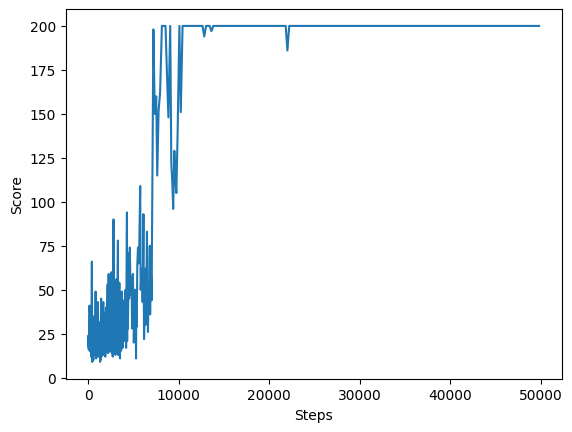

In [12]:
all_rewards = np.array(all_rewards)
plt.xlabel('Steps')
plt.ylabel('Score')
plt.plot(all_rewards[:, 0], all_rewards[:, 1])

In [13]:
env = Recorder(env, './video')
state = env.reset()
done = False
total_reward = 0.0
q_net.eval()
3
with torch.no_grad():
    while not done:
        action = q_net.choose_action(state)
        next_state, reward, done, info = env.step(action)
        total_reward += reward
        state = next_state

print(total_reward)
env.play()

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(



200.0
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [14]:
env_mountain = gym.make('MountainCar-v0')
env_mountain = Recorder(env_mountain, './video')
state = env_mountain.reset()
done = False
total_reward = 0.0

while not done:
    action = env_mountain.action_space.sample()
    next_state, reward, done, info = env_mountain.step(action)
    total_reward += reward
    state = next_state

print(total_reward)
env_mountain.play()


  deprecation(

  deprecation(

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(



-200.0
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [42]:
# Hyperparameters
max_epsilon = 0.6
min_epsilon = 0.1
max_num_steps = 50000
epsilon_decay_intervals = 1000
gamma = 0.99 # discount
alpha = 1e-4 # learning rate

memory_size = 500000
min_replay_size = 1000
batch_size = 64

target_update_frequency = 1000 # target network update frequency

In [ ]:
all_rewards, q_net = dqn_training(env_mountain, max_num_steps, max_epsilon, min_epsilon, epsilon_decay_intervals, gamma, lr=alpha)

Episode: 5 Step: 1000 Average reward: -200.0
Episode: 10 Step: 2000 Average reward: -200.0
Episode: 15 Step: 3000 Average reward: -200.0
Episode: 20 Step: 4000 Average reward: -200.0
Episode: 25 Step: 5000 Average reward: -200.0
Episode: 30 Step: 6000 Average reward: -200.0
Episode: 35 Step: 7000 Average reward: -200.0
Episode: 40 Step: 8000 Average reward: -200.0
Episode: 45 Step: 9000 Average reward: -200.0
Episode: 50 Step: 10000 Average reward: -200.0
Episode: 55 Step: 11000 Average reward: -200.0
Episode: 60 Step: 12000 Average reward: -200.0


In [ ]:
all_rewards = np.array(all_rewards)
plt.xlabel('Steps')
plt.ylabel('Score')
plt.plot(all_rewards[:, 0], all_rewards[:, 1])

In [ ]:
env = Recorder(env, './video')
state = env.reset()
done = False
total_reward = 0.0
q_net.eval()
3
with torch.no_grad():
    while not done:
        action = q_net.choose_action(state)
        next_state, reward, done, info = env.step(action)
        total_reward += reward
        state = next_state

print(total_reward)
env.play()